# TRAINING JUPYTER

In [1]:
# Imports et variables setting

# General Libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import keras
import datetime
from contextlib import redirect_stdout

# Current files
from generator import Diff_Generator, Basic_Generator, Up_and_Down_Generator
from preprocess import ProdKernel, FKernel, VarSuppression, Zero_One,  Level_Normalizer, Normalizer, DictPrepross
from generator import FC_Generator

from utils import Load_FLX_dict, Plot_Batch
from CST import CST

data_folder=  CST.Data_folder(CST)
model_folder = CST.Model_folder(CST)
log_folder = CST.Log_folder(CST)

Using TensorFlow backend.
/usr/lib/python3/dist-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### Parameter setting and preprocessing

In [2]:
np.random.seed(0)
D2 = []
D2 = [DictPrepross(['o3','pl','t'], [Level_Normalizer(False),Level_Normalizer(True), Level_Normalizer(False)] )]
D = [Load_FLX_dict()]
##### Kernels

Klist = []
fit_genator = Up_and_Down_Generator(folder=data_folder, batch_size=512, train=True, preprocess_x=D)

D2[0]['pl'].fit(fit_genator[0][0][:,:,3])
D2[0]['o3'].fit(fit_genator[0][0][:,:,2])
D2[0]['t'].fit(fit_genator[0][0][:,:,-2])

Klist =[]
#Klist = [ProdKernel([('o3', 'pl'),('t','pl'), ('t','q') ])]

# V
V = [VarSuppression(['ts', 'rl', 'ri','pl'])]

##### Full Preprocessing :
FP = D + D2 + Klist + V 
##### b_size
batch_size= 64

normal_generator = Basic_Generator(folder=data_folder, batch_size=100*batch_size)
train_generator =  Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=True, preprocess_x=FP)
validation_generator = Up_and_Down_Generator(folder=data_folder, batch_size=batch_size, train=False, preprocess_x=FP, custom_b_p_e = 50)

header_x = train_generator.used_variables
header_y = train_generator.new_variables_pred

in_channel=len(header_x)
o_channel = len(header_y)

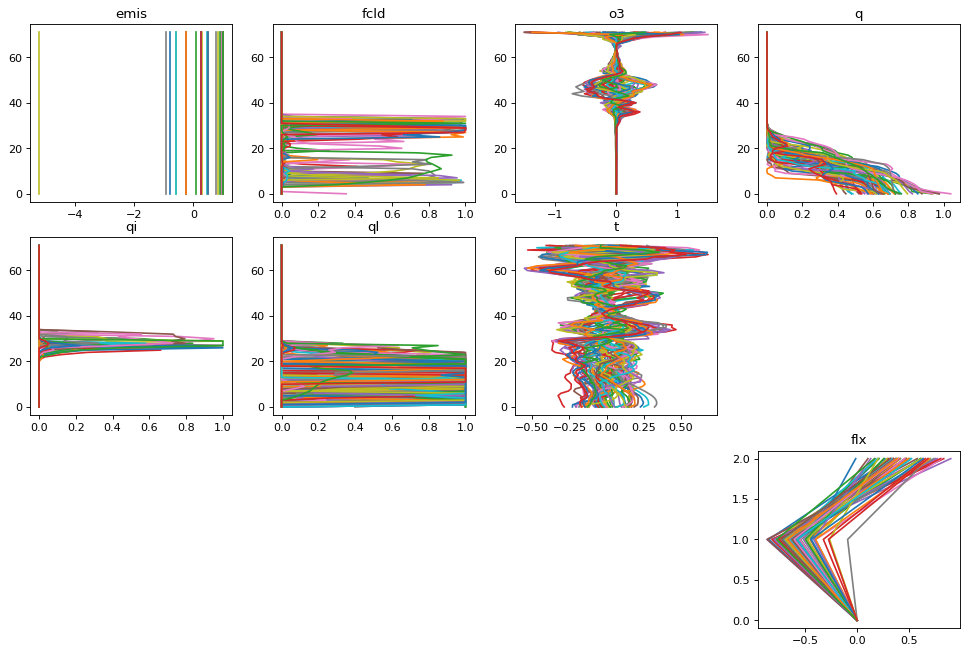

In [3]:
from utils import Plot_Batch

x,y = train_generator[0]

Plot_Batch(x,y[:,36],header_x, swap=True)

In [102]:
train_generator.batch_per_file

1944

In [106]:
1944*5

9720

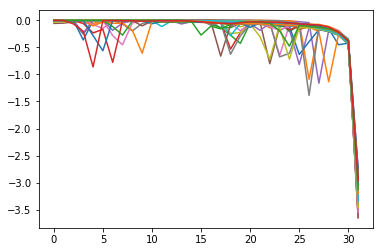

In [78]:
plt.plot(y[:,40:,2].T);

In [56]:
normal_generator = Up_and_Down_Generator(folder=data_folder, batch_size=100*batch_size)
normal_generator.new_variables_pred

['flxd', 'flxu', 'dfdts']

In [57]:
y0.shape

(6400, 3, 72)

In [77]:
a=np.zeros((72,3))
x0,y0 = normal_generator[0]
y0=y0.swapaxes(1,2)
for i in range(1,72):
    a[i,0] = np.max( abs((y0[:,0, :i])) )
    a[i,1] = np.max( abs((y0[:,1, :i])) )
    a[i,2] = np.max( abs((y0[:,2, :i])) )*50

b=np.zeros((72,3))
for i in range(1,72):
    b[i,0] = np.std( ((y0[:,0, :i])) )
    b[i,1] = np.std( ((y0[:,1, :i])) )
    b[i,2] = np.std( ((y0[:,2, :i])) )*50

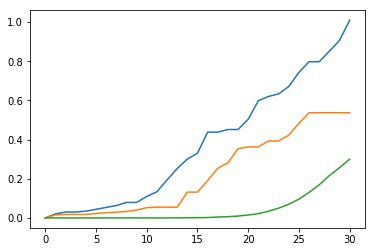

In [81]:
plt.plot(a[:31]);

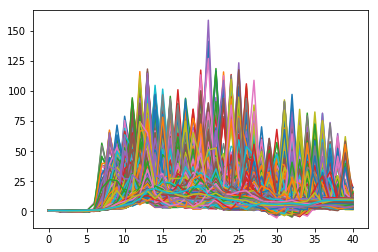

In [85]:
plt.plot(y0[:,0, 31:].T);
i

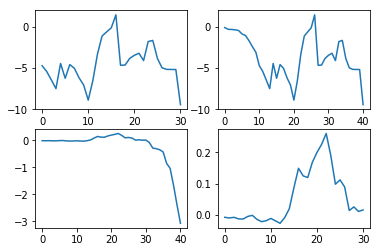

In [97]:
i=31

plt.subplot(221)
plt.plot(y[0,(72-i):,1]);
plt.subplot(222)
plt.plot(y[0,i:,1]);
plt.subplot(223)
plt.plot(y[0,:(72-i),1]);
plt.subplot(224)
plt.plot(y[0,:i,1]);

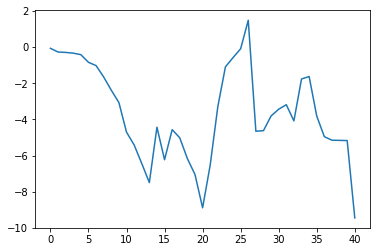

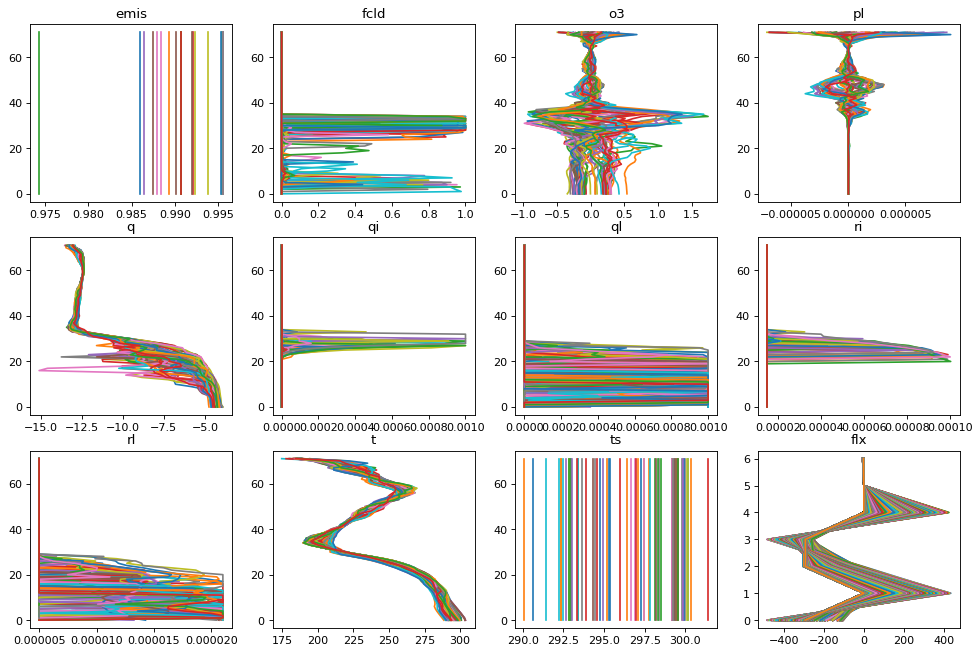

In [18]:
x,y = normal_generator[0]
x[:,3]=x[:,2]
x[:,3]-=np.mean(x[:,3], axis=0)

x[:,2]=np.log(x[:,2])
x[:,2]-=np.mean(x[:,2], axis=0)


x[:,4]=np.log(x[:,4])
#x=np.log(x+0.00001)
Plot_Batch(x,y, normal_generator.variables, swap=False)

In [26]:
t=x[:,:,-2].flatten()
t1 = x1[:,-2,].flatten()
np.corrcoef(t,t1)

array([[1.        , 0.00685751],
       [0.00685751, 1.        ]])

## II) ARCHITECTURES

### Load a model

In [101]:
#print(np.sqrt(60))
#print(np.sqrt(20))

7.745966692414834
4.47213595499958


In [36]:
M_Up.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 7, 72)             0         
_________________________________________________________________
up_sampling1d_5 (UpSampling1 (None, 35, 72)            0         
_________________________________________________________________
average_pooling1d_5 (Average (None, 7, 72)             0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [3]:
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log, Activation_Generator

### BD or BD+Unet

In [44]:
import keras
#from architectures_simples import Upsampler
from architectures import Unet_Act_Simple,  Bidir_Casual_Conv
from architectures_simples import Upsampler
from architectures_utils import total_loss, flxd_loss, flxu_loss, dfdts_loss, LossHistory,  Generate_Log
import keras.backend as K
from keras import optimizers
import datetime

lev=72
inter_channel=50
o_channel=3
ups=5
pooling=3
params_bd = []
params_u = [0.1]

"TrainedModels/20190521212840U.pickle"
list_of_filters_bdc=[[64, 32], [32, 20], [50]]
list_of_kernel_bdc=[[10, 5], [10, 5], [5]]
list_of_activations_bdc = [['leakyrelu','leakyrelu'],['leakyrelu','leakyrelu'],['leakyrelu']]

list_of_filters_unet=[[50, 75, 100], [270], [50, 75, 100]]
list_of_kernel_unet=[[10, 5, 3], [], [10, 5, 3]]
#list_of_activations_unet = [ ['leakyrelu', 'leakyrelu', 'leakyrelu'],['sigmoid'],['leakyrelu','leakyrelu','leakyrelu']]
list_of_activations_unet = [ ['elu', 'elu', 'elu'],['sigmoid'],['elu','elu','elu']]



M_Up = Upsampler(avg=5, pooling=22, input_shape=(lev, in_channel))
M_bd_cas = Bidir_Casual_Conv(list_of_kernel_bdc, list_of_filters_bdc, list_of_activations_bdc, \
                             params_bd, in_channel, lev=CST.lev(CST))
# unet
M_unet = Unet_Act_Simple(list_of_kernel_unet, list_of_filters_unet, list_of_activations_unet,\
                         params_u, Div=3, lev=72, in_channel=inter_channel, o_channel=o_channel)

M = keras.models.Sequential()
M.add(M_Up); M.layers[-1].name = 'Upsampler'
M.add(M_bd_cas); M.layers[-1].name = 'U_bd_cas'
M.add(M_unet); M.layers[-1].name = 'Unet'


Adam=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1.e-6)
#M.summary()
for l in M.layers:
    l.summary()

ValueError: Dimensions must be equal, but are 0 and 50 for 'elu_10/mul' (op: 'Mul') with input shapes: [1,0], [?,36,50].

In [53]:
from keras.layers import Input
from architectures_utils import Activation_Generator
I = Input(shape=(50,2))
AG = Activation_Generator()
Act = AG('elu', 'elu1', 0.1)(I)
print(Act.shape)

(?, 50, 2)


### Training

### ANALYSIS :

In [55]:
keras.layers.Activation('linear')

### Saving

In [ ]:
# IMPORTANT MODEL LOG SAVER
file = os.path.join(log_folder, prefix+archi+'.txt')
with open(file, 'w') as f:
    with redirect_stdout(f):
        print('Seed {}'.format(seed))
        print('Optimizer')
        print(Adam.get_config())
        print('Prepross')
        for P in FP:
            print(P)
        for model in models:
            model.summary()
        for k in history.history.keys():
            print(k,':', history.history[k])
        print('\n')
        print('Bdc')
        print('list_of_filters_bdc = ', list_of_filters_bdc)
        print('list_of_kernel_bdc = ', list_of_kernel_bdc)
        print('list_of_activation_bdc = ', list_of_activation_bdc)
        print('Unet')
        print('list_of_filters_unet = ',list_of_filters_unet)
        print('list_of_kernel_unet = ',list_of_kernel_unet)
        print('list_of_activation_unet = ', list_of_activation_unet)
        for loss in callback.losses:
            print(loss)

In [6]:
from utils import Plot_triple_diff_separated, F_and_plots

j=np.random.randint(batch_size)
i=np.random.randint(len(validation_generator))

x,y = validation_generator[i]
y0 = M.predict(x)
F=F_and_plots(shape=(3,3),figsize=(15,10))
print(i,j)
Plot_triple_diff_separated(F, y,y0, header_y, sep=35, j=j)

InternalError: cudnn PoolForward launch failed
	 [[Node: model_1/AVG_p/AvgPool = AvgPool[T=DT_FLOAT, data_format="NCHW", ksize=[1, 1, 3, 1], padding="SAME", strides=[1, 1, 5, 1], _device="/job:localhost/replica:0/task:0/device:GPU:0"](model_1/AVG_p/AvgPool-0-TransposeNHWCToNCHW-LayoutOptimizer)]]
	 [[Node: model_2/conv1d_1/convolution/Squeeze/_207 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_853_model_2/conv1d_1/convolution/Squeeze", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [4]:
from contextlib import redirect_stdout
with open(os.path.join(log_folder, prefix), 'w') as f:
    with redirect_stdout(f):
        print('Seed {}'.format(seed))
        modelbd2.summary()
        modelbd.summary()
        for loss in FP:
            print(loss)
        print(history.history)

NameError: name 'seed' is not defined

### VISUALISATION

In [145]:
def Compare(y,y0, i=0):
    f=plt.figure( figsize=(15,8), dpi=80)
    ax= f.add_subplot(1,2,1)
    ax.plot(np.flip(y0[i]), np.arange(len(y0[i]))) 
    ax.plot(np.flip(y[i]), np.arange(len(y0[i]))) 
    ax.legend(["y pred", 'y truth'])
#    ax.title("Diff")
    y_cumsum = np.cumsum(y[i])
    y0_cumsum = np.cumsum(y0[i])
    ax= f.add_subplot(1,2,2)
    ax.plot(np.flip(y0_cumsum), np.arange(len(y0[i])))        
    ax.plot(np.flip(y_cumsum), np.arange(len(y0[i])))        
    ax.legend(["y pred", 'y truth'])
#    ax.title("Cumulative")
    plt.show()

def eliminate_all_but_1(m,x):
    O = []
    for i in range(11):
        x0= x.copy()
        x0*=0
        x0[:,:,i]=x[:,:,i]
        O.append(m.predict(x0))
    O.append(x.copy)
    return(np.array(O))

def eliminate_one(m,x):
    O = []
    for i in range(11):
        x0= x.copy()
        x0[:,:,i]*=0
        O.append(m.predict(x0))
    O.append(m.predict(x0)*0)
    return(np.array(O))


def Plot_Predictions(O, y, header):
    f=plt.figure( figsize=(15,10), dpi=80)
    for i,y0 in enumerate(O):
        ax= f.add_subplot(3,4,i+1)
        ax.set_title(header[i])
        for b in range(y0.shape[0]):
            ax.plot(np.flip(y0[b]), np.arange(len(y0[b])))
    ax= f.add_subplot(3,4,12)
    ax.set_title('flx')
    for b in range(y0.shape[0]):
        ax.plot(np.flip(y[b]), np.arange(len(y[b])))

def Normal2(x,header):
    O1 = []#['fcld', 'q','qi','ql','rl','ri']
    N = [ 'pl']
    STD = []
    STD2 = []
    for i, h in enumerate(header):
        if h in O1:
            x[:,:,i] = np.max(x[:,:,i], axis=1).reshape(x.shape[0],1)
        if h in N:
            #print(h, np.mean(x[:,:,i], axis=0)[32])
            x[:,:,i] -= np.mean(x[:,:,i], axis=0)
        if h in STD:
            x[:,:,i] /= (x[:,-1,i]+0.000000001).reshape(-1,1)         
        if h in STD2:
            x[:,:,i] /= (x[:,0,i]+0.000000001).reshape(-1,1)         
    return(x)


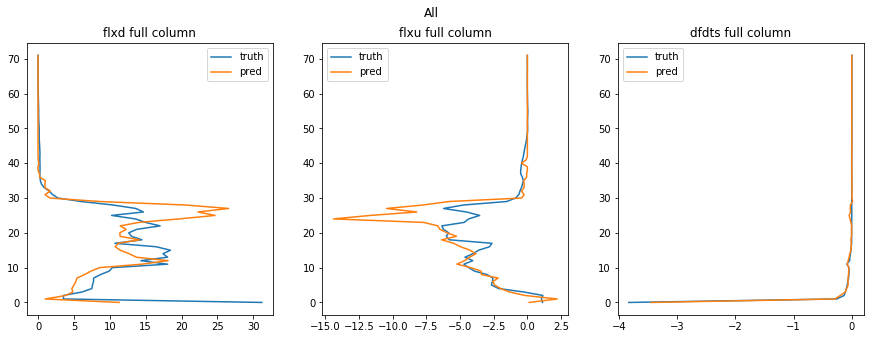

<Figure size 1080x576 with 0 Axes>

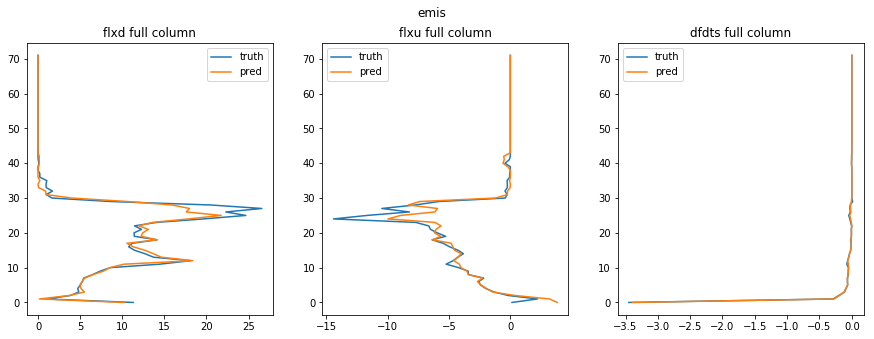

<Figure size 1080x576 with 0 Axes>

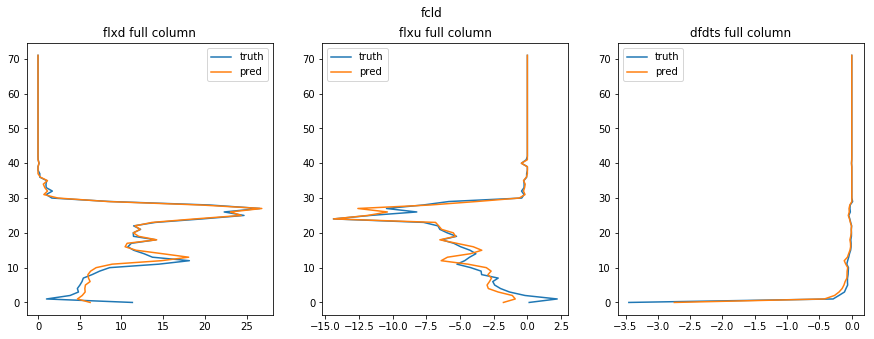

<Figure size 1080x576 with 0 Axes>

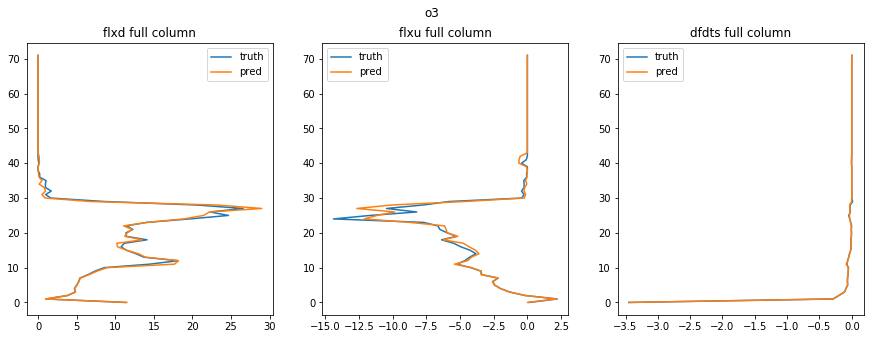

<Figure size 1080x576 with 0 Axes>

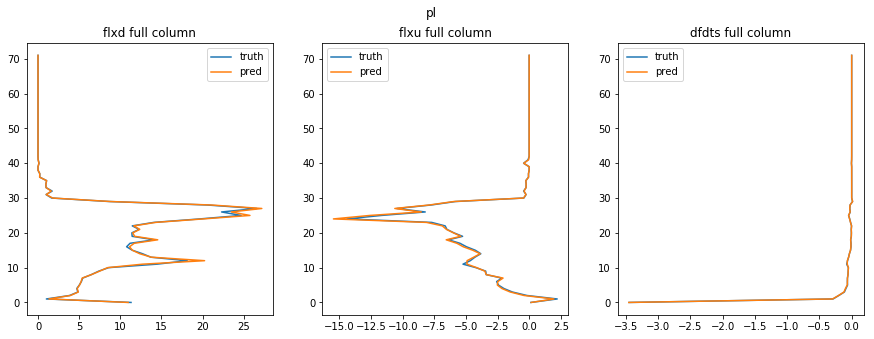

<Figure size 1080x576 with 0 Axes>

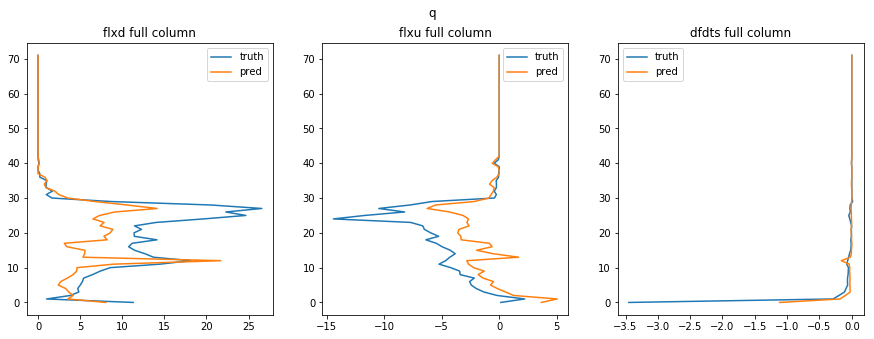

<Figure size 1080x576 with 0 Axes>

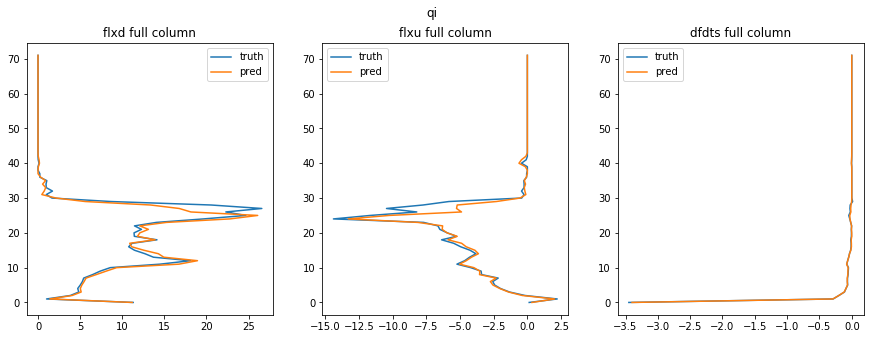

<Figure size 1080x576 with 0 Axes>

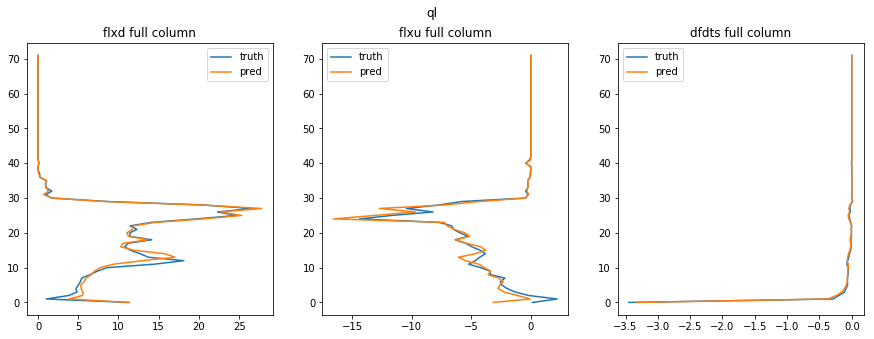

<Figure size 1080x576 with 0 Axes>

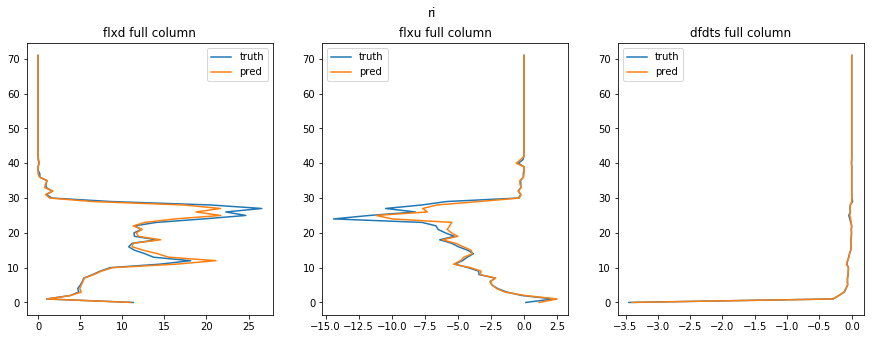

<Figure size 1080x576 with 0 Axes>

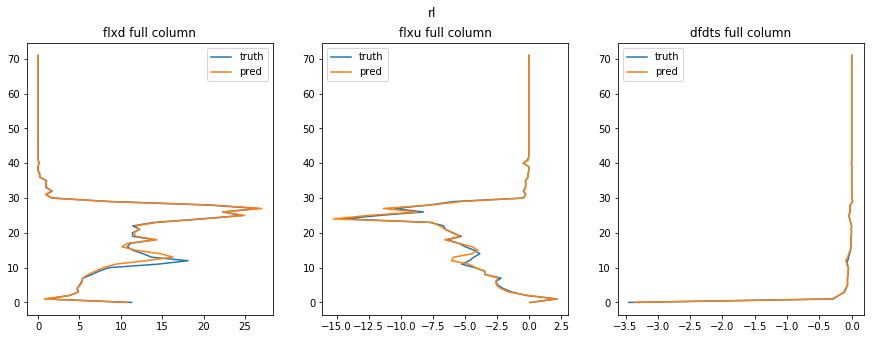

<Figure size 1080x576 with 0 Axes>

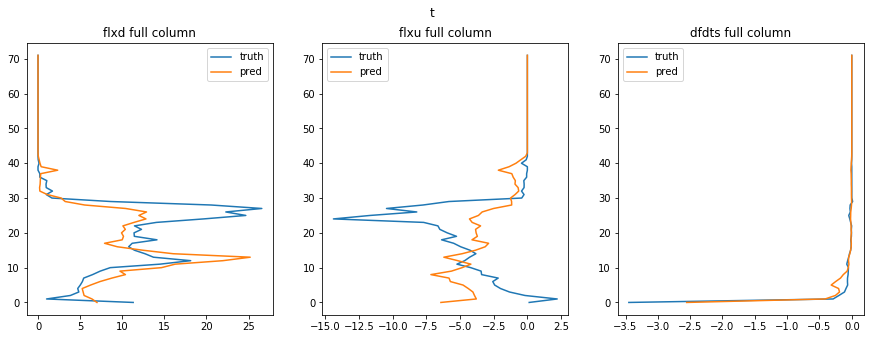

<Figure size 1080x576 with 0 Axes>

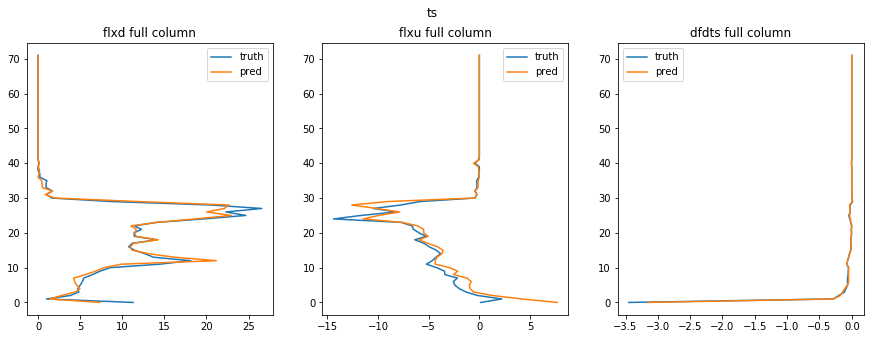

<Figure size 1080x576 with 0 Axes>

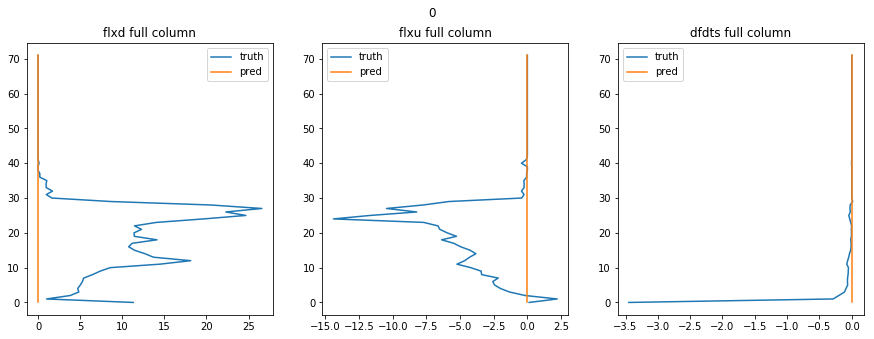

<Figure size 1080x576 with 0 Axes>

In [146]:
x,y = validation_generator[ validation_generator.ids_to_index((0,4,np.random.randint(1000))) ]
O1 = eliminate_one(M,x)
O0 = eliminate_all_but_1(M,x)

y_pred = []
y0 = M.predict(x)
F = F_and_plots((1,3), figsize=(15,5))
F.f.suptitle("All")
j=60
Plot_triple_diff_separated(F  , y, y0, header_y, sep=0, j=j)

for i in range(12):
#    y_pred.append(model_bd_avg_2.predict(X[i]))
    F = F_and_plots((1,3), figsize=(15,5))
    if i==11:
        F.f.suptitle('0')
    else:
        F.f.suptitle(header_x[i])        
    Plot_triple_diff_separated(F  , y0, O1[i], header_y, sep=0, j=j)

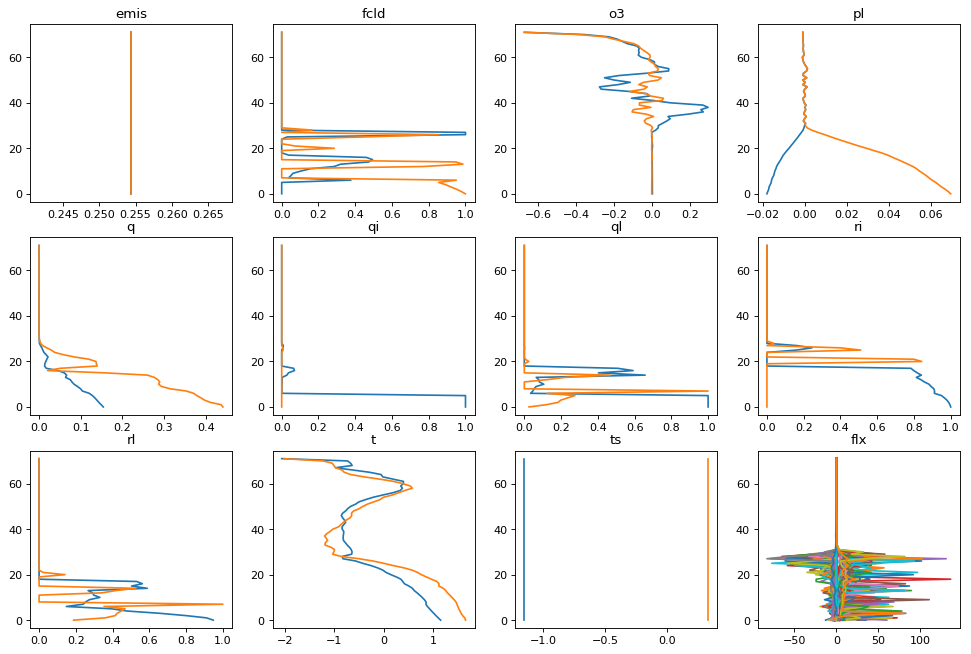

In [138]:
Plot_Batch(x.swapaxes(1,2)[[0,60]],y, header_x)

In [121]:
def RMSE(model, x,y_true):
    y_pred = model.predict(x)
    rmse = np.sqrt(np.mean(K.get_value(flxd_loss(y_true, y_pred))))
    return(rmse)

In [125]:
RMSE(M,x, y)

4.056657

### SECOND ARCHITECTURE :
Not tested yet

# III) TRACKS 

### MODEL 2 :

- FCNN
- (with AE)

##### MODEL 2 : FCM-Final FC

##### MODEL 2 : U-net :
- use regular U-net so all layers affect each other and more stability

### MODEL 3 : Bidir-LSTM 
> Possible alternatives

- use two LSTM to show both impact of superior and inferior layer
- use attention model over it
- use w embeddings before

> TD

- Read git trez
- Read article of Hedge fun